<a href="https://colab.research.google.com/github/jenboland/DailyKnowledge/blob/master/MMM_Impressions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [79]:
!pip install pymc_marketing

In [80]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

from pymc_marketing.mmm import MMM, GeometricAdstock, LogisticSaturation
from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation

warnings.filterwarnings("ignore", category=FutureWarning)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [82]:
path_ = "/content/drive/MyDrive/Colab Notebooks/"

In [83]:
bing = pd.read_csv(path_+'cafb_bing_daily.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()
dm = pd.read_csv(path_+'cafb_direct_mail_daily.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()
email = pd.read_csv(path_+'cafb_email_daily.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()
fb = pd.read_csv(path_+'cafb_facebook_daily.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()
paid_search = pd.read_csv(path_+'cafb_google_paid_search.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()
prog = pd.read_csv(path_+'cafb_programmatic_daily.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()
sales = pd.read_csv(path_+'cafb_transactions.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()
ftf = pd.read_excel(path_+'CAFB MMM Telefundraising Data 2022-2024v2.xlsx', sheet_name = 'transposed', parse_dates=['timestamp']).fillna(0).rename(columns={'timestamp':'Date'}).set_index('Date').resample('W').sum()

fb = fb.rename(columns={'Impressions':'FB_Impressions', 'Spend':'FB_Spend'})
ftf = ftf.rename(columns={'calls':'FTF_Impressions', 'funds':'FTF_Spend'})

In [84]:
inflation = pd.read_excel(path_+'Economic_Data.xlsx', sheet_name='Inflation', index_col=None)
inflation = inflation.set_index('Date')
inflation = inflation.resample('W').ffill()
inflation.head()

,Annual_Inflation_Rate
Date,
2022-01-02,7.5
2022-01-09,7.5
2022-01-16,7.5
2022-01-23,7.5
2022-01-30,7.5


In [85]:
unemployment = pd.read_excel(path_+'Economic_Data.xlsx', sheet_name='Unemployment', index_col=None)
# Convert the 'Date' column to datetime objects before setting it as the index
unemployment['Date'] = pd.to_datetime(unemployment['Date'])
unemployment = unemployment.set_index('Date')
unemployment = unemployment.resample('W').ffill()
unemployment.head()

,Unemployment_Rate
Date,
2022-01-02,4.0
2022-01-09,4.0
2022-01-16,4.0
2022-01-23,4.0
2022-01-30,4.0


In [86]:
stock_market = pd.read_excel(path_+'Economic_Data.xlsx', sheet_name='Stock_Market', index_col=None)
stock_market = stock_market.set_index('Date')
stock_market= stock_market.resample('W').mean()
stock_market.head()

,Stock_Close
Date,
2022-01-09,4732.752
2022-01-16,4686.318
2022-01-23,4497.635
2022-01-30,4374.974
2022-02-06,4525.888


In [87]:
cci = pd.read_excel(path_+'Economic_Data.xlsx', sheet_name='CCI', index_col=None)
cci = cci.set_index('Date')
cci = cci.resample('W').ffill()
cci.head()


,CCI
Date,
2022-01-02,97.7494
2022-01-09,97.7494
2022-01-16,97.7494
2022-01-23,97.7494
2022-01-30,97.7494


In [88]:
consumer_demand = pd.read_excel(path_+'Economic_Data.xlsx', sheet_name='Consumer_Demand', index_col=None)
consumer_demand = consumer_demand.set_index('Date')
consumer_demand.head()

,Consumer_Demand
Date,
2022-01-02,0
2022-01-09,28
2022-01-16,24
2022-01-23,0
2022-01-30,24


In [89]:
df = pd.concat([bing, dm, email, fb, paid_search, prog, ftf ,sales, consumer_demand, cci, unemployment, inflation, stock_market], axis=1).fillna(0).head(144)

In [90]:
# prompt: I have a column consumer demand. I want to divide Bing_Branded_Impressions, GoogleAds_Branded_Impressions by Consumer_Demand. If Consumer_Demand is 0, then divide by 1

# Assuming your dataframe is named 'df'
df['Bing_Branded_Impressions_Normalized'] = df['Bing_Branded_Impressions'] / df['Consumer_Demand'].replace(0, 1)
df['GoogleAds_Branded_Impressions_Normalized'] = df['GoogleAds_Branded_Impressions'] / df['Consumer_Demand'].replace(0, 1)

In [91]:
df.columns

Index(['Bing_Branded_Impressions', 'Bing_Branded_Spend',
       'Bing_NonBranded_Impressions', 'Bing_NonBranded_Spend', 'DM_Spend',
       'DM_Impressions', 'Email_Impressions', 'Email_Spend', 'FB_Spend',
       'FB_Impressions', 'GoogleAds_Branded_Impressions',
       'GoogleAds_Branded_Spend', 'GoogleAds_NonBranded_Impressions',
       'GoogleAds_NonBranded_Spend', 'Programatic_Spend',
       'Programatic_Impressions', 'FTF_Spend', 'FTF_Impressions', 'contacts',
       'Revenue', 'Consumer_Demand', 'CCI', 'Unemployment_Rate',
       'Annual_Inflation_Rate', 'Stock_Close',
       'Bing_Branded_Impressions_Normalized',
       'GoogleAds_Branded_Impressions_Normalized'],
      dtype='object')

In [92]:
df

,Bing_Branded_Impressions,Bing_Branded_Spend,Bing_NonBranded_Impressions,Bing_NonBranded_Spend,DM_Spend,DM_Impressions,Email_Impressions,Email_Spend,FB_Spend,FB_Impressions,...,FTF_Impressions,contacts,Revenue,Consumer_Demand,CCI,Unemployment_Rate,Annual_Inflation_Rate,Stock_Close,Bing_Branded_Impressions_Normalized,GoogleAds_Branded_Impressions_Normalized
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-02,1.0,3.26,3852.0,210.97,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,44191.70,0.0,97.74940,4.0,7.5,0.0000,1.000000,147.000000
2022-01-09,64.0,8.25,4482.0,757.49,0.0,0.0,0.0,0.0,0.00,0.0,...,6487.0,561.0,99989.50,28.0,97.74940,4.0,7.5,4732.7520,2.285714,28.785714
2022-01-16,11.0,7.87,5217.0,823.99,0.0,0.0,0.0,0.0,0.00,0.0,...,10886.0,914.0,147772.39,24.0,97.74940,4.0,7.5,4686.3180,0.458333,36.083333
2022-01-23,31.0,20.69,9084.0,834.35,0.0,0.0,111374.0,1000.0,0.00,0.0,...,1378.0,99.0,134056.43,0.0,97.74940,4.0,7.5,4497.6350,31.000000,908.000000
2022-01-30,19.0,22.09,11871.0,835.66,0.0,0.0,0.0,0.0,0.00,0.0,...,3511.0,507.0,229189.84,24.0,97.74940,4.0,7.5,4374.9740,0.791667,30.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-01,137.0,223.57,768.0,493.42,0.0,0.0,0.0,0.0,1284.14,373499.0,...,0.0,0.0,156221.84,16.0,98.06518,4.1,2.4,5615.0360,8.562500,49.125000
2024-09-08,174.0,245.35,424.0,410.70,0.0,0.0,0.0,0.0,1282.05,389795.0,...,0.0,0.0,199752.84,14.0,98.06518,4.1,2.4,5490.2075,12.428571,58.285714
2024-09-15,208.0,224.73,362.0,434.44,0.0,0.0,0.0,0.0,1284.53,364030.0,...,0.0,0.0,162318.56,0.0,98.06518,4.1,2.4,5548.4960,208.000000,836.000000


In [93]:
input_df = df[['Revenue',
               *[c for c in df.columns if 'Impressions' in c], # Existing channel columns
               'Consumer_Demand', 'CCI', 'Unemployment_Rate', 'Annual_Inflation_Rate', 'Stock_Close'  # Economic control columns
              ]]
spend_df = df[['Revenue', *[c for c in df.columns if 'Spend' in c]]]

In [94]:
input_df

,Revenue,Bing_Branded_Impressions,Bing_NonBranded_Impressions,DM_Impressions,Email_Impressions,FB_Impressions,GoogleAds_Branded_Impressions,GoogleAds_NonBranded_Impressions,Programatic_Impressions,FTF_Impressions,Bing_Branded_Impressions_Normalized,GoogleAds_Branded_Impressions_Normalized,Consumer_Demand,CCI,Unemployment_Rate,Annual_Inflation_Rate,Stock_Close
Date,,,,,,,,,,,,,,,,,
2022-01-02,44191.70,1.0,3852.0,0.0,0.0,0.0,147.0,1365.0,0.0,0.0,1.000000,147.000000,0.0,97.74940,4.0,7.5,0.0000
2022-01-09,99989.50,64.0,4482.0,0.0,0.0,0.0,806.0,7085.0,0.0,6487.0,2.285714,28.785714,28.0,97.74940,4.0,7.5,4732.7520
2022-01-16,147772.39,11.0,5217.0,0.0,0.0,0.0,866.0,6520.0,0.0,10886.0,0.458333,36.083333,24.0,97.74940,4.0,7.5,4686.3180
2022-01-23,134056.43,31.0,9084.0,0.0,111374.0,0.0,908.0,5910.0,0.0,1378.0,31.000000,908.000000,0.0,97.74940,4.0,7.5,4497.6350
2022-01-30,229189.84,19.0,11871.0,0.0,0.0,0.0,722.0,6567.0,0.0,3511.0,0.791667,30.083333,24.0,97.74940,4.0,7.5,4374.9740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-01,156221.84,137.0,768.0,0.0,0.0,373499.0,786.0,4048.0,243539.0,0.0,8.562500,49.125000,16.0,98.06518,4.1,2.4,5615.0360
2024-09-08,199752.84,174.0,424.0,0.0,0.0,389795.0,816.0,4090.0,282064.0,0.0,12.428571,58.285714,14.0,98.06518,4.1,2.4,5490.2075
2024-09-15,162318.56,208.0,362.0,0.0,0.0,364030.0,836.0,4093.0,274108.0,0.0,208.000000,836.000000,0.0,98.06518,4.1,2.4,5548.4960


In [95]:
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)


#df = spend_df.copy()
df = input_df.copy()
df = df.reset_index()

df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['dayofyear'] = df['Date'].dt.dayofyear

n = df.shape[0]
print(f"Number of observations: {n}")

Number of observations: 144


In [96]:
df

,Date,Revenue,Bing_Branded_Impressions,Bing_NonBranded_Impressions,DM_Impressions,Email_Impressions,FB_Impressions,GoogleAds_Branded_Impressions,GoogleAds_NonBranded_Impressions,Programatic_Impressions,...,Bing_Branded_Impressions_Normalized,GoogleAds_Branded_Impressions_Normalized,Consumer_Demand,CCI,Unemployment_Rate,Annual_Inflation_Rate,Stock_Close,year,month,dayofyear
0,2022-01-02,44191.70,1.0,3852.0,0.0,0.0,0.0,147.0,1365.0,0.0,...,1.000000,147.000000,0.0,97.74940,4.0,7.5,0.0000,2022,1,2
1,2022-01-09,99989.50,64.0,4482.0,0.0,0.0,0.0,806.0,7085.0,0.0,...,2.285714,28.785714,28.0,97.74940,4.0,7.5,4732.7520,2022,1,9
2,2022-01-16,147772.39,11.0,5217.0,0.0,0.0,0.0,866.0,6520.0,0.0,...,0.458333,36.083333,24.0,97.74940,4.0,7.5,4686.3180,2022,1,16
3,2022-01-23,134056.43,31.0,9084.0,0.0,111374.0,0.0,908.0,5910.0,0.0,...,31.000000,908.000000,0.0,97.74940,4.0,7.5,4497.6350,2022,1,23
4,2022-01-30,229189.84,19.0,11871.0,0.0,0.0,0.0,722.0,6567.0,0.0,...,0.791667,30.083333,24.0,97.74940,4.0,7.5,4374.9740,2022,1,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,2024-09-01,156221.84,137.0,768.0,0.0,0.0,373499.0,786.0,4048.0,243539.0,...,8.562500,49.125000,16.0,98.06518,4.1,2.4,5615.0360,2024,9,245
140,2024-09-08,199752.84,174.0,424.0,0.0,0.0,389795.0,816.0,4090.0,282064.0,...,12.428571,58.285714,14.0,98.06518,4.1,2.4,5490.2075,2024,9,252
141,2024-09-15,162318.56,208.0,362.0,0.0,0.0,364030.0,836.0,4093.0,274108.0,...,208.000000,836.000000,0.0,98.06518,4.1,2.4,5548.4960,2024,9,259
142,2024-09-22,163221.03,72.0,35.0,0.0,0.0,373172.0,816.0,3778.0,139614.0,...,2.322581,26.322581,31.0,98.06518,4.1,2.4,5660.4240,2024,9,266


In [97]:
df["eoy_campaign"] = df["Date"].apply(lambda x: 1 if x.month in [11, 12] else 0)
df["end_of_year"] = (df["Date"].dt.month == 12) & (df["Date"].dt.day == 31)

In [98]:
df['trend'] = df['Revenue'].shift(1).fillna(method="bfill")

In [99]:
df.columns

Index(['Date', 'Revenue', 'Bing_Branded_Impressions',
       'Bing_NonBranded_Impressions', 'DM_Impressions', 'Email_Impressions',
       'FB_Impressions', 'GoogleAds_Branded_Impressions',
       'GoogleAds_NonBranded_Impressions', 'Programatic_Impressions',
       'FTF_Impressions', 'Bing_Branded_Impressions_Normalized',
       'GoogleAds_Branded_Impressions_Normalized', 'Consumer_Demand', 'CCI',
       'Unemployment_Rate', 'Annual_Inflation_Rate', 'Stock_Close', 'year',
       'month', 'dayofyear', 'eoy_campaign', 'end_of_year', 'trend'],
      dtype='object')

In [100]:
# trend feature
data = df.copy()

#data["t"] = range(n)

data.head()

,Date,Revenue,Bing_Branded_Impressions,Bing_NonBranded_Impressions,DM_Impressions,Email_Impressions,FB_Impressions,GoogleAds_Branded_Impressions,GoogleAds_NonBranded_Impressions,Programatic_Impressions,...,CCI,Unemployment_Rate,Annual_Inflation_Rate,Stock_Close,year,month,dayofyear,eoy_campaign,end_of_year,trend
0,2022-01-02,44191.70,1.0,3852.0,0.0,0.0,0.0,147.0,1365.0,0.0,...,97.7494,4.0,7.5,0.000,2022,1,2,0,False,44191.70
1,2022-01-09,99989.50,64.0,4482.0,0.0,0.0,0.0,806.0,7085.0,0.0,...,97.7494,4.0,7.5,4732.752,2022,1,9,0,False,44191.70
2,2022-01-16,147772.39,11.0,5217.0,0.0,0.0,0.0,866.0,6520.0,0.0,...,97.7494,4.0,7.5,4686.318,2022,1,16,0,False,99989.50
3,2022-01-23,134056.43,31.0,9084.0,0.0,111374.0,0.0,908.0,5910.0,0.0,...,97.7494,4.0,7.5,4497.635,2022,1,23,0,False,147772.39
4,2022-01-30,229189.84,19.0,11871.0,0.0,0.0,0.0,722.0,6567.0,0.0,...,97.7494,4.0,7.5,4374.974,2022,1,30,0,False,134056.43


In [101]:
data.columns

Index(['Date', 'Revenue', 'Bing_Branded_Impressions',
       'Bing_NonBranded_Impressions', 'DM_Impressions', 'Email_Impressions',
       'FB_Impressions', 'GoogleAds_Branded_Impressions',
       'GoogleAds_NonBranded_Impressions', 'Programatic_Impressions',
       'FTF_Impressions', 'Bing_Branded_Impressions_Normalized',
       'GoogleAds_Branded_Impressions_Normalized', 'Consumer_Demand', 'CCI',
       'Unemployment_Rate', 'Annual_Inflation_Rate', 'Stock_Close', 'year',
       'month', 'dayofyear', 'eoy_campaign', 'end_of_year', 'trend'],
      dtype='object')

In [102]:
spend_df.columns

Index(['Revenue', 'Bing_Branded_Spend', 'Bing_NonBranded_Spend', 'DM_Spend',
       'Email_Spend', 'FB_Spend', 'GoogleAds_Branded_Spend',
       'GoogleAds_NonBranded_Spend', 'Programatic_Spend', 'FTF_Spend'],
      dtype='object')

In [103]:
spend_df[[ 'Bing_Branded_Spend', 'Bing_NonBranded_Spend', 'DM_Spend',
       'Email_Spend', 'FB_Spend', 'GoogleAds_Branded_Spend',
       'GoogleAds_NonBranded_Spend', 'Programatic_Spend','FTF_Spend']].sum(axis=0)

,0
Bing_Branded_Spend,2.122165e+04
Bing_NonBranded_Spend,5.996311e+04
DM_Spend,1.596722e+06
Email_Spend,4.600000e+04
FB_Spend,2.432722e+04
GoogleAds_Branded_Spend,4.170892e+04
GoogleAds_NonBranded_Spend,7.533248e+04
Programatic_Spend,3.537012e+04
FTF_Spend,2.305580e+05


In [104]:
input_df.columns

Index(['Revenue', 'Bing_Branded_Impressions', 'Bing_NonBranded_Impressions',
       'DM_Impressions', 'Email_Impressions', 'FB_Impressions',
       'GoogleAds_Branded_Impressions', 'GoogleAds_NonBranded_Impressions',
       'Programatic_Impressions', 'FTF_Impressions',
       'Bing_Branded_Impressions_Normalized',
       'GoogleAds_Branded_Impressions_Normalized', 'Consumer_Demand', 'CCI',
       'Unemployment_Rate', 'Annual_Inflation_Rate', 'Stock_Close'],
      dtype='object')

In [105]:
input_df[[ 'Bing_Branded_Impressions_Normalized', 'Bing_NonBranded_Impressions',
       'DM_Impressions', 'Email_Impressions', 'FB_Impressions',
       'GoogleAds_Branded_Impressions_Normalized', 'GoogleAds_NonBranded_Impressions',
       'Programatic_Impressions', 'FTF_Impressions']].sum(axis=0)

,0
Bing_Branded_Impressions_Normalized,3.899952e+03
Bing_NonBranded_Impressions,5.689700e+05
DM_Impressions,2.089808e+06
Email_Impressions,4.401968e+06
FB_Impressions,3.061127e+06
GoogleAds_Branded_Impressions_Normalized,1.824415e+04
GoogleAds_NonBranded_Impressions,4.512430e+05
Programatic_Impressions,7.659514e+06
FTF_Impressions,1.820970e+05


In [106]:
total_spend_per_channel = spend_df[[ 'Bing_Branded_Spend', 'Bing_NonBranded_Spend', 'DM_Spend',
       'Email_Spend', 'FB_Spend', 'GoogleAds_Branded_Spend',
       'GoogleAds_NonBranded_Spend', 'Programatic_Spend','FTF_Spend']].sum(axis=0)

spend_share = total_spend_per_channel / total_spend_per_channel.sum()

spend_share

,0
Bing_Branded_Spend,0.009958
Bing_NonBranded_Spend,0.028136
DM_Spend,0.749211
Email_Spend,0.021584
FB_Spend,0.011415
GoogleAds_Branded_Spend,0.019571
GoogleAds_NonBranded_Spend,0.035347
Programatic_Spend,0.016596
FTF_Spend,0.108182


In [107]:
total_impressions_per_channel = input_df[[ 'Bing_Branded_Impressions_Normalized', 'Bing_NonBranded_Impressions',
       'DM_Impressions', 'Email_Impressions', 'FB_Impressions',
       'GoogleAds_Branded_Impressions_Normalized', 'GoogleAds_NonBranded_Impressions',
       'Programatic_Impressions', 'FTF_Impressions']].sum(axis=0)

impressions_share = total_impressions_per_channel / total_impressions_per_channel.sum()

impressions_share

,0
Bing_Branded_Impressions_Normalized,0.000212
Bing_NonBranded_Impressions,0.030860
DM_Impressions,0.113349
Email_Impressions,0.238759
FB_Impressions,0.166033
GoogleAds_Branded_Impressions_Normalized,0.000990
GoogleAds_NonBranded_Impressions,0.024475
Programatic_Impressions,0.415445
FTF_Impressions,0.009877


In [108]:
spend_df.columns

Index(['Revenue', 'Bing_Branded_Spend', 'Bing_NonBranded_Spend', 'DM_Spend',
       'Email_Spend', 'FB_Spend', 'GoogleAds_Branded_Spend',
       'GoogleAds_NonBranded_Spend', 'Programatic_Spend', 'FTF_Spend'],
      dtype='object')

In [109]:
n_channels = 8

prior_sigma = n_channels * impressions_share.to_numpy()

prior_sigma.tolist()

[0.0016922400755013038,
 0.24688353977184338,
 0.9067950796764618,
 1.9100716062400158,
 1.3282631236289497,
 0.00791637603407027,
 0.1958002515726065,
 3.32356350818495,
 0.07901427481560251]

In [110]:
X = data.drop("Revenue", axis=1)
y = data["Revenue"]

In [111]:
X.columns


Index(['Date', 'Bing_Branded_Impressions', 'Bing_NonBranded_Impressions',
       'DM_Impressions', 'Email_Impressions', 'FB_Impressions',
       'GoogleAds_Branded_Impressions', 'GoogleAds_NonBranded_Impressions',
       'Programatic_Impressions', 'FTF_Impressions',
       'Bing_Branded_Impressions_Normalized',
       'GoogleAds_Branded_Impressions_Normalized', 'Consumer_Demand', 'CCI',
       'Unemployment_Rate', 'Annual_Inflation_Rate', 'Stock_Close', 'year',
       'month', 'dayofyear', 'eoy_campaign', 'end_of_year', 'trend'],
      dtype='object')

In [112]:
#X.gt_2023.unique()

In [113]:
dummy_model = MMM(
    date_column="",
    channel_columns=[""],
    adstock=GeometricAdstock(l_max=4),
    saturation=LogisticSaturation(),
)
dummy_model.default_model_config

{'intercept': Prior("Normal", mu=0, sigma=2),
 'likelihood': Prior("Normal", sigma=Prior("HalfNormal", sigma=2)),
 'gamma_control': Prior("Normal", mu=0, sigma=2, dims="control"),
 'gamma_fourier': Prior("Laplace", mu=0, b=1, dims="fourier_mode"),
 'adstock_alpha': Prior("Beta", alpha=1, beta=3, dims="channel"),
 'saturation_lam': Prior("Gamma", alpha=3, beta=1, dims="channel"),
 'saturation_beta': Prior("HalfNormal", sigma=2, dims="channel")}

In [114]:
import pymc_marketing.mmm as mmm
dir(mmm)


['AdstockTransformation',
 'BaseValidateMMM',
 'DelayedAdstock',
 'GeometricAdstock',
 'HillSaturation',
 'HillSaturationSigmoid',
 'InverseScaledLogisticSaturation',
 'LinearTrend',
 'LogisticSaturation',
 'MMM',
 'MMMModelBuilder',
 'MediaConfig',
 'MediaConfigList',
 'MediaTransformation',
 'MichaelisMentenSaturation',
 'MonthlyFourier',
 'RootSaturation',
 'SaturationTransformation',
 'TanhSaturation',
 'TanhSaturationBaselined',
 'WeibullCDFAdstock',
 'WeibullPDFAdstock',
 'YearlyFourier',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'adstock_from_dict',
 'base',
 'budget_optimizer',
 'components',
 'fourier',
 'lift_test',
 'linear_trend',
 'media_transformation',
 'mmm',
 'plot',
 'preprocessing',
 'preprocessing_method_X',
 'preprocessing_method_y',
 'register_adstock_transformation',
 'register_saturation_transformation',
 'saturation_from_dict',
 'transformers',
 'tvp',
 'utils',
 '

In [150]:
from pymc_marketing.mmm.transformers import geometric_adstock

# Convert DM column to NumPy array before applying adstock
dm_adstock = geometric_adstock(
    x=data["DM_Impressions"].values,  # Convert to NumPy array
    alpha=0.6,            # Retention rate
    l_max=12,             # Maximum lag
    normalize=True        # Normalize weights
).eval()  # Ensure evaluation happens for tensor

# Convert DM column to NumPy array before applying adstock
em_adstock = geometric_adstock(
    x=data["Email_Impressions"].values,  # Convert to NumPy array
    alpha=0.1,            # Retention rate
    l_max=1,             # Maximum lag
    normalize=True        # Normalize weights
).eval()  # Ensure evaluation happens for tensor

# Convert DM column to NumPy array before applying adstock
fb_adstock = geometric_adstock(
    x=data["FB_Impressions"].values,  # Convert to NumPy array
    alpha=0.3,            # Retention rate
    l_max=2,             # Maximum lag
    normalize=True        # Normalize weights
).eval()  # Ensure evaluation happens for tensor

# Convert DM column to NumPy array before applying adstock
prog_adstock = geometric_adstock(
    x=data["Programatic_Impressions"].values,  # Convert to NumPy array
    alpha=0.3,            # Retention rate
    l_max=3,             # Maximum lag
    normalize=True        # Normalize weights
).eval()  # Ensure evaluation happens for tensor

# Convert DM column to NumPy array before applying adstock
ftf_adstock = geometric_adstock(
    x=data["FTF_Impressions"].values,  # Convert to NumPy array
    alpha=0.4,            # Retention rate
    l_max=3,             # Maximum lag
    normalize=True        # Normalize weights
).eval()  # Ensure evaluation happens for tensor


# Add the transformed column back to your DataFrame
X = data.copy()
X["DM_adstock"] = dm_adstock
X.drop(columns=["DM_Impressions"], inplace=True)  # Replace original DM if necessary

X["Email_adstock"] = em_adstock
X.drop(columns=["Email_Impressions"], inplace=True)  # Replace original DM if necessary
X["Programatic_adstock"] = prog_adstock
X.drop(columns=["Programatic_Impressions"], inplace=True)  # Replace original DM if necessary
X["FB_adstock"] = fb_adstock
X.drop(columns=["FB_Impressions"], inplace=True)  # Replace original DM if necessary
X["FTF_adstock"] = ftf_adstock
X.drop(columns=["FTF_Impressions"], inplace=True)  # Replace original DM if necessary


In [151]:
my_model_config = {
    "intercept": {"dist": "HalfNormal", "kwargs": {"sigma": 10}},  # Positive-only intercept
    "saturation_beta": {"dist": "HalfNormal", "kwargs": {"sigma": 1}},
    "alpha": {"dist": "Beta", "kwargs": {"alpha": 2, "beta": 3}},  # Adstock decay
    "gamma_control": {"dist": "Normal", "kwargs": {"mu": 10, "sigma": 3}},
    "gamma_fourier": {"dist": "Laplace", "kwargs": {"mu": 0, "b": 1}},  # For seasonality
    "likelihood": {
        "dist": "Normal",
        "kwargs": {"sigma": {"dist": "Exponential", "kwargs": {"lam": 1 / 10}}},
    },
}



my_model_config = {
    "intercept": {"dist": "HalfNormal", "kwargs": {"sigma": 10}},  # Positive-only intercept
    "saturation_beta": {"dist": "HalfNormal", "kwargs": {"sigma": 1}},
    "alpha": {"dist": "Beta", "kwargs": {"alpha": 2, "beta": 3}},  # Adstock decay
    "gamma_control": {"dist": "Normal", "kwargs": {"mu": 10, "sigma": 3}},
    "gamma_fourier": {"dist": "Laplace", "kwargs": {"mu": 0, "b": 1}},  # For seasonality
    "likelihood": {
        "dist": "Normal",
        "kwargs": {"sigma": {"dist": "Exponential", "kwargs": {"lam": 1 / 10}}},
    },
}



In [152]:
my_sampler_config = {"progressbar": True}

In [153]:
X.columns

Index(['Date', 'Revenue', 'Bing_Branded_Impressions',
       'Bing_NonBranded_Impressions', 'GoogleAds_Branded_Impressions',
       'GoogleAds_NonBranded_Impressions',
       'Bing_Branded_Impressions_Normalized',
       'GoogleAds_Branded_Impressions_Normalized', 'Consumer_Demand', 'CCI',
       'Unemployment_Rate', 'Annual_Inflation_Rate', 'Stock_Close', 'year',
       'month', 'dayofyear', 'eoy_campaign', 'end_of_year', 'trend',
       'DM_adstock', 'Email_adstock', 'Programatic_adstock', 'FB_adstock',
       'FTF_adstock'],
      dtype='object')

In [154]:
mmm = MMM(
    model_config=my_model_config,
    sampler_config=my_sampler_config,
    date_column="Date",
    adstock=GeometricAdstock(l_max=8),
    saturation=LogisticSaturation(),
    channel_columns=['Bing_Branded_Impressions_Normalized',
       'Bing_NonBranded_Impressions', 'DM_adstock', 'Email_adstock',
       'FB_adstock', 'GoogleAds_Branded_Impressions_Normalized',
       'GoogleAds_NonBranded_Impressions', 'Programatic_adstock',
       'FTF_adstock'],
    control_columns=[
                'end_of_year', 'eoy_campaign', 'trend'
    ],
    yearly_seasonality=2,
)

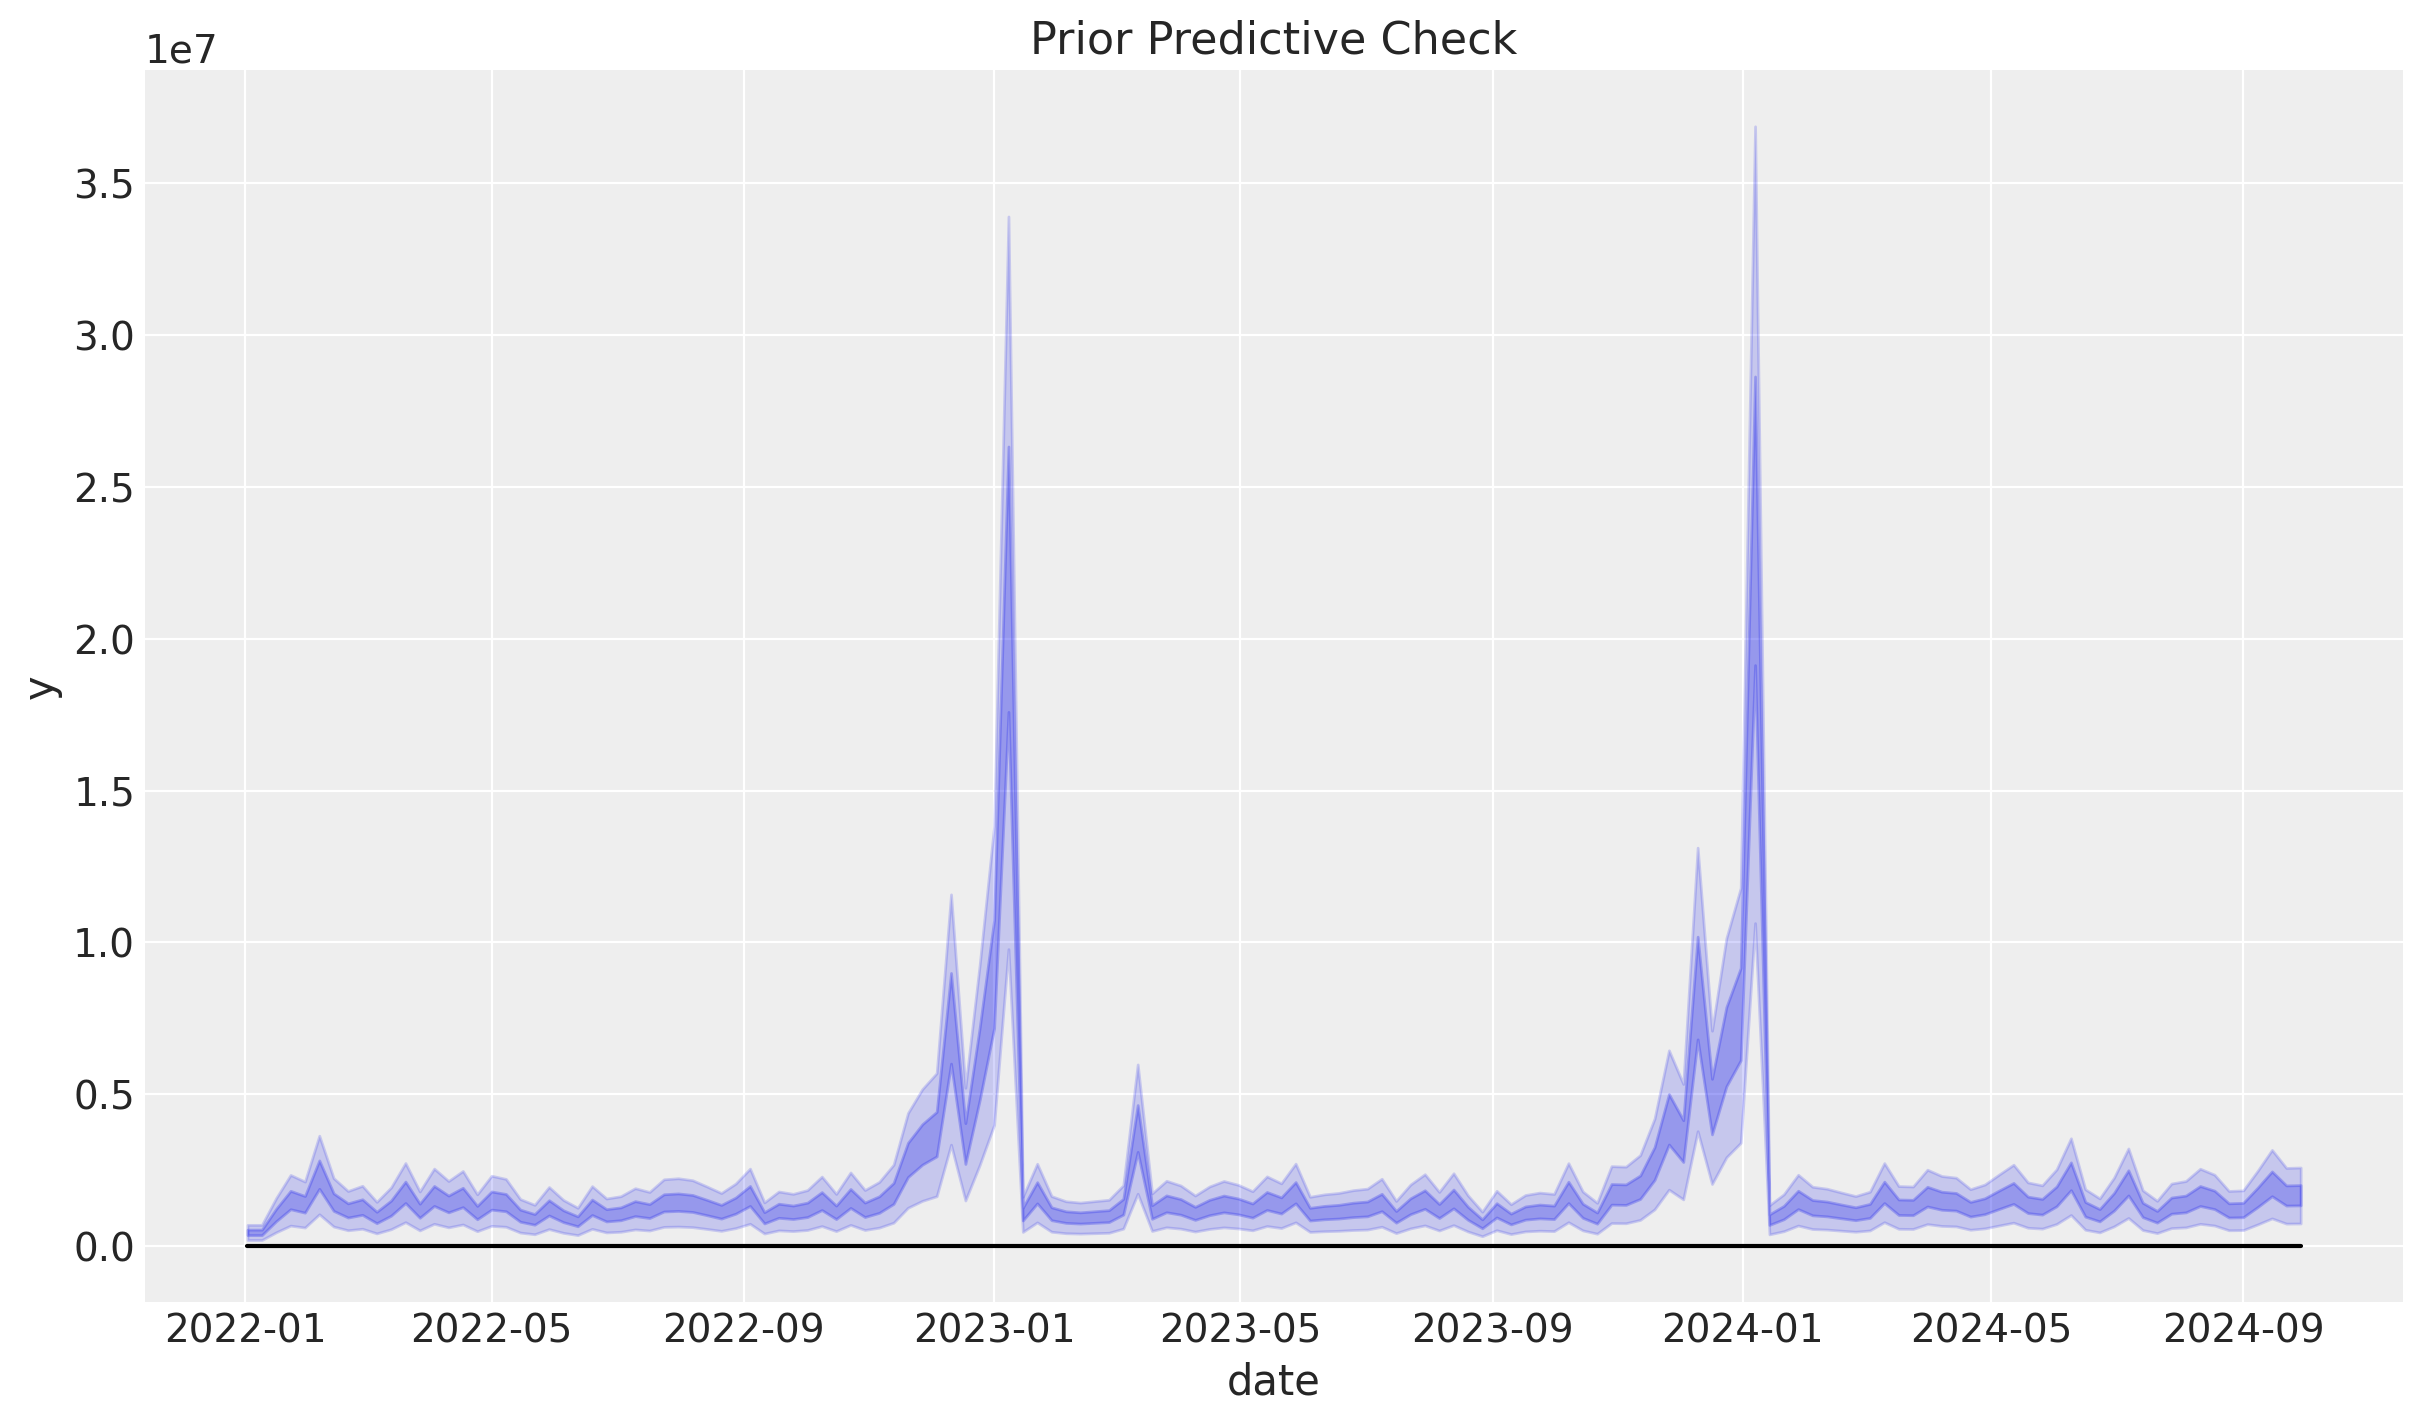

In [155]:
# Generate prior predictive samples
mmm.sample_prior_predictive(X, y, samples=2_000)

mmm.plot_prior_predictive();

In [156]:
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

In [157]:
mmm.fit(X=X, y=y, target_accept=0.95, chains=4, random_seed=rng)

Output()

Output()

Output()

Output()

Inference data with groups:
	> posterior
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data
	> fit_data

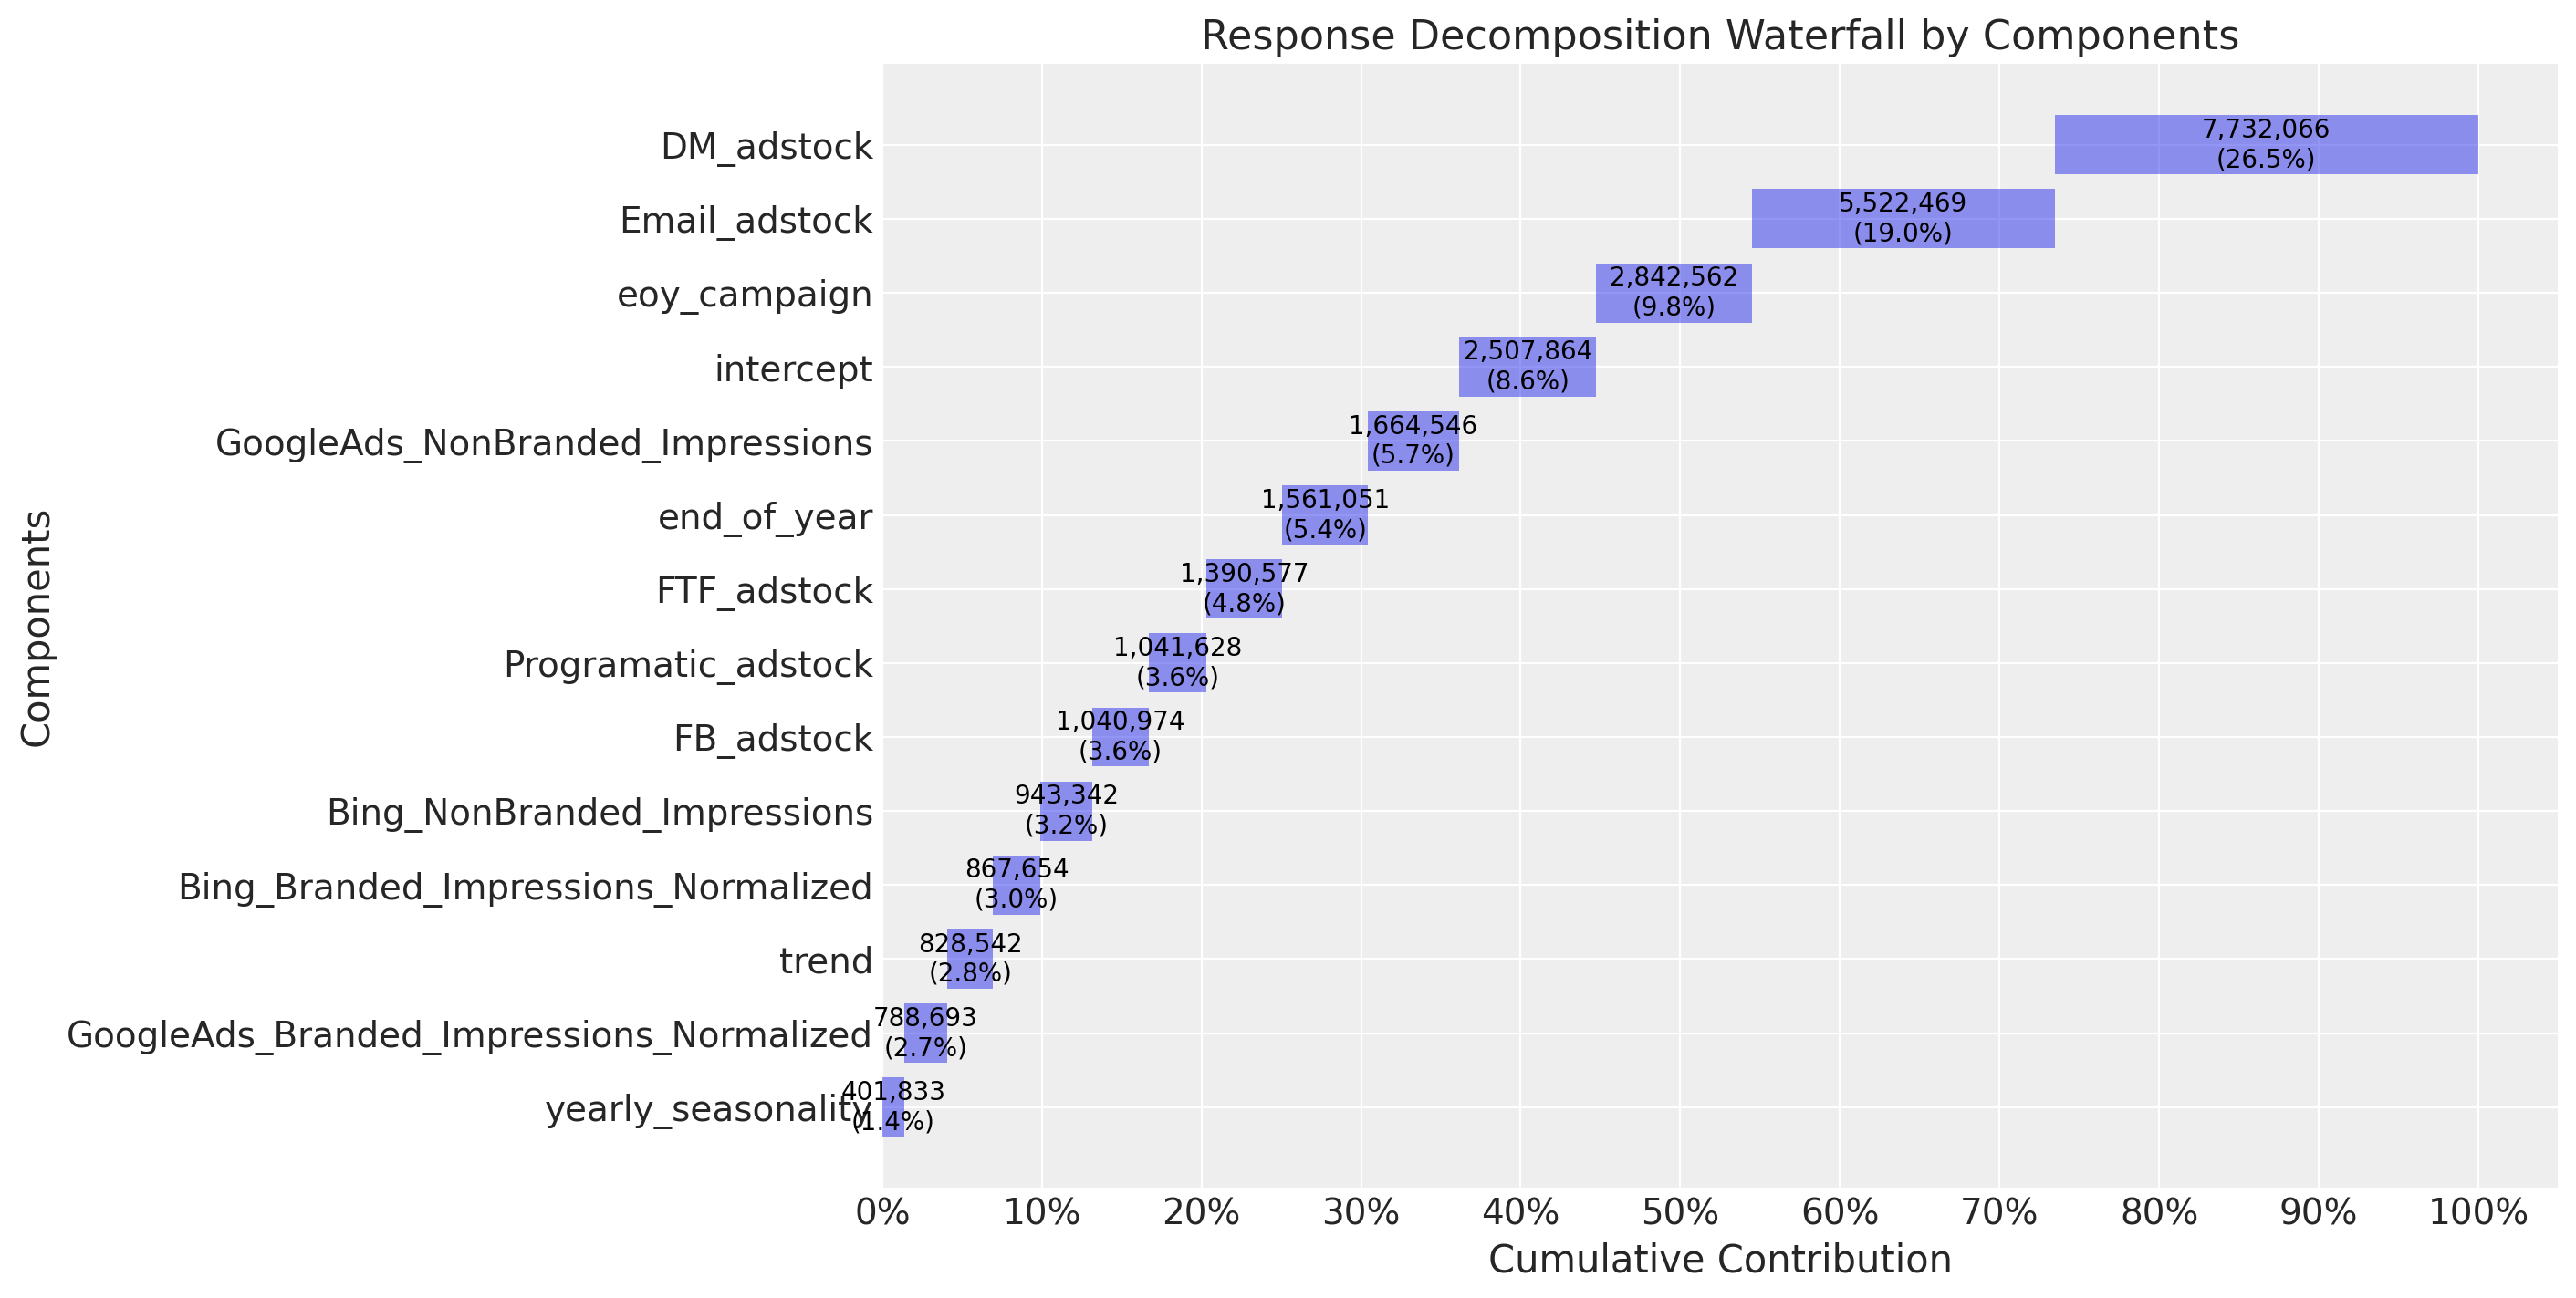

In [158]:
mmm.plot_waterfall_components_decomposition();

In [160]:
get_mean_contributions_over_time_df = mmm.compute_mean_contributions_over_time(
    original_scale=True
)

get_mean_contributions_over_time_df.head()

,Bing_Branded_Impressions_Normalized,Bing_NonBranded_Impressions,DM_adstock,Email_adstock,FB_adstock,GoogleAds_Branded_Impressions_Normalized,GoogleAds_NonBranded_Impressions,Programatic_adstock,FTF_adstock,end_of_year,eoy_campaign,trend,yearly_seasonality,intercept
date,,,,,,,,,,,,,,
2022-01-02,179.168906,5023.691350,0.0,0.000000,0.0,5089.946693,4288.115032,0.0,0.000000,0.0,0.0,1302.273316,39885.862139,17415.720495
2022-01-09,448.415710,6865.753783,0.0,0.000000,0.0,2115.113531,17506.539673,0.0,21491.624529,0.0,0.0,1302.273316,47103.524178,17415.720495
2022-01-16,184.666188,8332.947971,0.0,0.000000,0.0,1862.167706,18810.114026,0.0,43714.926345,0.0,0.0,2946.563670,52030.915359,17415.720495
2022-01-23,5570.339237,13605.265243,0.0,130527.306977,0.0,25258.377986,18516.030234,0.0,35688.885368,0.0,0.0,4354.664798,54564.697553,17415.720495
2022-01-30,1370.411172,18122.936911,0.0,10068.586529,0.0,7867.241302,19532.899689,0.0,31768.423646,0.0,0.0,3950.472863,54730.864780,17415.720495


In [161]:
get_mean_contributions_over_time_df.sum().sum()

29133799.26068149

In [162]:
y.sum()

28155353.659999985

In [163]:
attr = get_mean_contributions_over_time_df.sum()/get_mean_contributions_over_time_df.sum().sum()*100
attr

,0
Bing_Branded_Impressions_Normalized,2.978169
Bing_NonBranded_Impressions,3.237963
DM_adstock,26.539847
Email_adstock,18.955539
FB_adstock,3.573079
GoogleAds_Branded_Impressions_Normalized,2.707140
GoogleAds_NonBranded_Impressions,5.713452
Programatic_adstock,3.575326
FTF_adstock,4.773072
end_of_year,5.358214


In [166]:
attr.loc[[       'end_of_year', 'eoy_campaign', 'trend', 'intercept', 'yearly_seasonality']].sum()

27.946411988961366

In [167]:
X.columns

Index(['Date', 'Revenue', 'Bing_Branded_Impressions',
       'Bing_NonBranded_Impressions', 'GoogleAds_Branded_Impressions',
       'GoogleAds_NonBranded_Impressions',
       'Bing_Branded_Impressions_Normalized',
       'GoogleAds_Branded_Impressions_Normalized', 'Consumer_Demand', 'CCI',
       'Unemployment_Rate', 'Annual_Inflation_Rate', 'Stock_Close', 'year',
       'month', 'dayofyear', 'eoy_campaign', 'end_of_year', 'trend',
       'DM_adstock', 'Email_adstock', 'Programatic_adstock', 'FB_adstock',
       'FTF_adstock'],
      dtype='object')

In [195]:
input_df.columns

Index(['Revenue', 'Bing_Branded_Impressions', 'Bing_NonBranded_Impressions',
       'DM_Impressions', 'Email_Impressions', 'FB_Impressions',
       'GoogleAds_Branded_Impressions', 'GoogleAds_NonBranded_Impressions',
       'Programatic_Impressions', 'FTF_Impressions',
       'Bing_Branded_Impressions_Normalized',
       'GoogleAds_Branded_Impressions_Normalized', 'Consumer_Demand', 'CCI',
       'Unemployment_Rate', 'Annual_Inflation_Rate', 'Stock_Close'],
      dtype='object')

In [196]:
spend_df.columns

Index(['Revenue', 'Bing_Branded_Spend', 'Bing_NonBranded_Spend', 'DM_Spend',
       'Email_Spend', 'FB_Spend', 'GoogleAds_Branded_Spend',
       'GoogleAds_NonBranded_Spend', 'Programatic_Spend', 'FTF_Spend'],
      dtype='object')

In [197]:
attr

,0
Bing_Branded_Impressions_Normalized,2.98
Bing_NonBranded_Impressions,3.24
DM_adstock,26.54
Email_adstock,18.96
FB_adstock,3.57
GoogleAds_Branded_Impressions_Normalized,2.71
GoogleAds_NonBranded_Impressions,5.71
Programatic_adstock,3.58
FTF_adstock,4.77
end_of_year,5.36


In [198]:
attr_df = pd.DataFrame(attr, columns=['attr'])  # Create a DataFrame from attr
attr_df['Channel'] = attr_df.index  # Set the index as a new 'Channel' column
attr_df = attr_df.reset_index(drop=True)  # Reset the index
attr_df = attr_df[['Channel', 'attr']]  # Reorder columns

attr_df

,Channel,attr
0,Bing_Branded_Impressions_Normalized,2.98
1,Bing_NonBranded_Impressions,3.24
2,DM_adstock,26.54
3,Email_adstock,18.96
4,FB_adstock,3.57
5,GoogleAds_Branded_Impressions_Normalized,2.71
6,GoogleAds_NonBranded_Impressions,5.71
7,Programatic_adstock,3.58
8,FTF_adstock,4.77
9,end_of_year,5.36


In [199]:
# Rename columns in attr_df
column_mapping = {
    'Bing_Branded_Impressions_Normalized': 'Bing_Branded',
    'Bing_NonBranded_Impressions': 'Bing_NonBranded',
    'DM_adstock': 'DM',
    'Email_adstock': 'Email',
    'FB_adstock': 'FB',
    'GoogleAds_Branded_Impressions_Normalized': 'GoogleAds_Branded',
    'GoogleAds_NonBranded_Impressions': 'GoogleAds_NonBranded',
    'Programatic_adstock': 'Programatic',
    'FTF_adstock': 'FTF',
}

attr_df['Channel'] = attr_df['Channel'].replace(column_mapping)  # Replace values in 'Channel' column

attr_df

,Channel,attr
0,Bing_Branded,2.98
1,Bing_NonBranded,3.24
2,DM,26.54
3,Email,18.96
4,FB,3.57
5,GoogleAds_Branded,2.71
6,GoogleAds_NonBranded,5.71
7,Programatic,3.58
8,FTF,4.77
9,end_of_year,5.36


In [202]:
input_df.columns


Index(['Revenue', 'Bing_Branded_Impressions', 'Bing_NonBranded_Impressions',
       'DM_Impressions', 'Email_Impressions', 'FB_Impressions',
       'GoogleAds_Branded_Impressions', 'GoogleAds_NonBranded_Impressions',
       'Programatic_Impressions', 'FTF_Impressions',
       'Bing_Branded_Impressions_Normalized',
       'GoogleAds_Branded_Impressions_Normalized', 'Consumer_Demand', 'CCI',
       'Unemployment_Rate', 'Annual_Inflation_Rate', 'Stock_Close'],
      dtype='object')

In [200]:
attr_df['attr'] = attr_df['attr'] / 100  # Divide 'attr' column by 100

attr_df

,Channel,attr
0,Bing_Branded,0.03
1,Bing_NonBranded,0.03
2,DM,0.27
3,Email,0.19
4,FB,0.04
5,GoogleAds_Branded,0.03
6,GoogleAds_NonBranded,0.06
7,Programatic,0.04
8,FTF,0.05
9,end_of_year,0.05


In [216]:
# prompt: Using dataframe attr_df: add a column Revenue which is attr * 28,155,353.66

# Calculate the revenue based on the given formula
attr_df['Revenue'] = attr_df['attr'] * 28155353.66

# Display the updated dataframe to see the new column
attr_df

,Channel,attr,Revenue
0,Bing_Branded,0.03,"838,514.04"
1,Bing_NonBranded,0.03,"911,660.01"
2,DM,0.27,"7,472,387.92"
3,Email,0.19,"5,336,999.10"
4,FB,0.04,"1,006,012.97"
5,GoogleAds_Branded,0.03,"762,204.86"
6,GoogleAds_NonBranded,0.06,"1,608,642.62"
7,Programatic,0.04,"1,006,645.75"
8,FTF,0.05,"1,343,875.26"
9,end_of_year,0.05,"1,508,624.12"


In [203]:
attr_df.columns

Index(['Channel', 'attr'], dtype='object')

In [210]:
# Sum each column in input_df
column_sums = input_df.sum()

# Create a DataFrame from the column sums
impressions_df = pd.DataFrame(column_sums, columns=['Sum'])  # Transpose to have columns as rows
#impressions_df = impressions_df.rename(index={impressions_df.index[0]: 'Channel'})


impressions_df

,Sum
Revenue,"28,155,353.66"
Bing_Branded_Impressions,"15,140.00"
Bing_NonBranded_Impressions,"568,970.00"
DM_Impressions,"2,089,808.00"
Email_Impressions,"4,401,968.00"
FB_Impressions,"3,061,127.00"
GoogleAds_Branded_Impressions,"82,344.00"
GoogleAds_NonBranded_Impressions,"451,243.00"
Programatic_Impressions,"7,659,514.00"
FTF_Impressions,"182,097.00"


In [217]:
impressions_df = pd.DataFrame(column_sums, columns=['Impressions'])
impressions_df.index.name = 'Channel'  # Set the name of the index to 'Channel'

impressions_df

,Impressions
Channel,
Revenue,"28,155,353.66"
Bing_Branded_Impressions,"15,140.00"
Bing_NonBranded_Impressions,"568,970.00"
DM_Impressions,"2,089,808.00"
Email_Impressions,"4,401,968.00"
FB_Impressions,"3,061,127.00"
GoogleAds_Branded_Impressions,"82,344.00"
GoogleAds_NonBranded_Impressions,"451,243.00"
Programatic_Impressions,"7,659,514.00"


In [218]:
column_mapping = {
    'Bing_Branded_Impressions': 'Bing_Branded',
    'Bing_NonBranded_Impressions': 'Bing_NonBranded',
    'DM_Impressions': 'DM',
    'Email_Impressions': 'Email',
    'FB_Impressions': 'FB',
    'GoogleAds_Branded_Impressions': 'GoogleAds_Branded',
    'GoogleAds_NonBranded_Impressions': 'GoogleAds_NonBranded',
    'Programatic_Impressions': 'Programatic',
    'FTF_Impressions': 'FTF',
}

impressions_df.index = impressions_df.index.to_series().replace(column_mapping)

impressions_df



,Impressions
Channel,
Revenue,"28,155,353.66"
Bing_Branded,"15,140.00"
Bing_NonBranded,"568,970.00"
DM,"2,089,808.00"
Email,"4,401,968.00"
FB,"3,061,127.00"
GoogleAds_Branded,"82,344.00"
GoogleAds_NonBranded,"451,243.00"
Programatic,"7,659,514.00"


In [208]:
# Sum each column in input_df
column_sums = spend_df.sum()

# Create a DataFrame from the column sums
spend_df_sum = pd.DataFrame(column_sums, columns=['Sum'])  # Transpose to have columns as rows

spend_df_sum


,Sum
Revenue,"28,155,353.66"
Bing_Branded_Spend,"21,221.65"
Bing_NonBranded_Spend,"59,963.11"
DM_Spend,"1,596,722.00"
Email_Spend,"46,000.00"
FB_Spend,"24,327.22"
GoogleAds_Branded_Spend,"41,708.92"
GoogleAds_NonBranded_Spend,"75,332.48"
Programatic_Spend,"35,370.12"
FTF_Spend,"230,558.00"


In [219]:
spend_df_sum_df = pd.DataFrame(column_sums, columns=['Spend'])
spend_df_sum.index.name = 'Channel'  # Set the name of the index to 'Channel'

spend_df_sum

,Sum
Channel,
Revenue,"28,155,353.66"
Bing_Branded_Spend,"21,221.65"
Bing_NonBranded_Spend,"59,963.11"
DM_Spend,"1,596,722.00"
Email_Spend,"46,000.00"
FB_Spend,"24,327.22"
GoogleAds_Branded_Spend,"41,708.92"
GoogleAds_NonBranded_Spend,"75,332.48"
Programatic_Spend,"35,370.12"


In [220]:
column_mapping = {
    'Bing_Branded_Spend': 'Bing_Branded',
    'Bing_NonBranded_Spend': 'Bing_NonBranded',
    'DM_Spend': 'DM',
    'Email_Spend': 'Email',
    'FB_Spend': 'FB',
    'GoogleAds_Branded_Spend': 'GoogleAds_Branded',
    'GoogleAds_NonBranded_Spend': 'GoogleAds_NonBranded',
    'Programatic_Spend': 'Programatic',
    'FTF_Spend': 'FTF',
}

# Replace the index values instead of a column
spend_df_sum.index = spend_df_sum.index.to_series().replace(column_mapping)
spend_df_sum

,Sum
Channel,
Revenue,"28,155,353.66"
Bing_Branded,"21,221.65"
Bing_NonBranded,"59,963.11"
DM,"1,596,722.00"
Email,"46,000.00"
FB,"24,327.22"
GoogleAds_Branded,"41,708.92"
GoogleAds_NonBranded,"75,332.48"
Programatic,"35,370.12"


In [230]:
# Merge attr_df and impressions_df on 'Channel'
merged_df = pd.merge(attr_df, impressions_df, on='Channel', how='left')

# Merge the result with spend_df_sum on 'Channel'
final_merged_df = pd.merge(merged_df, spend_df_sum, on='Channel', how='left')
final_merged_df = final_merged_df.rename(columns={'Sum': 'Spend'})

# Create the 'CPM' column
final_merged_df['Effectiveness'] = final_merged_df['Spend'] / final_merged_df['Impressions']

final_merged_df['ROAS'] = final_merged_df['Revenue'] / final_merged_df['Spend']
final_merged_df['CPDR'] = final_merged_df['Spend'] / final_merged_df['Revenue']


final_merged_df

,Channel,attr,Revenue,Impressions,Spend,Effectiveness,ROAS,CPDR
0,Bing_Branded,0.03,"838,514.04","15,140.00","21,221.65",1.40,39.51,0.03
1,Bing_NonBranded,0.03,"911,660.01","568,970.00","59,963.11",0.11,15.20,0.07
2,DM,0.27,"7,472,387.92","2,089,808.00","1,596,722.00",0.76,4.68,0.21
3,Email,0.19,"5,336,999.10","4,401,968.00","46,000.00",0.01,116.02,0.01
4,FB,0.04,"1,006,012.97","3,061,127.00","24,327.22",0.01,41.35,0.02
5,GoogleAds_Branded,0.03,"762,204.86","82,344.00","41,708.92",0.51,18.27,0.05
6,GoogleAds_NonBranded,0.06,"1,608,642.62","451,243.00","75,332.48",0.17,21.35,0.05
7,Programatic,0.04,"1,006,645.75","7,659,514.00","35,370.12",0.00,28.46,0.04
8,FTF,0.05,"1,343,875.26","182,097.00","230,558.00",1.27,5.83,0.17
9,end_of_year,0.05,"1,508,624.12",NaN,NaN,NaN,NaN,NaN
